#### Using siamese network for change detection
- Not using contrastive loss

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

#### Preprocessing the data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import rasterio
import rioxarray
import xarray as xr
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score

In [4]:
from collections import Counter
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        try:
            img = rioxarray.open_rasterio(i)
            img_size.append(img.shape)
        except:
            pass
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        try:
            img = rioxarray.open_rasterio(i)
            if img.shape != size:
                img_path.remove(i)
        except:
            pass
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        try:
            img = rioxarray.open_rasterio(i)
            black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
        except:
            pass
    img_path_median = []
    for i in range(len(img_path_list)):
        try: 
            if black_pixels[i] <= np.median(black_pixels):
                img_path_median.append(img_path_list[i])
        except:
            pass
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        try: 
            img = rioxarray.open_rasterio(i)
            white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))
        except:
            pass

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        try:
            if white_pixels[i] <= np.mean(white_pixels):
                img_path_mean_white.append(img_path_list[i])
        except:
            pass
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white



def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."
    

# def label_csv(clean_img_path):
#     df = pd.DataFrame(columns=['image_path', 'day'])
#     for i in clean_img_path:
#         date_in = i.split('/')[-1].split('_')[0]
#         year = date_in[0:4]
#         month = date_in[4:6]
#         day = date_in[6:8]
#         date_string = f"{year}-{month}-{day}"
#         df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
#     df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
#     print("Class distribution in dataset:", df.label.value_counts())
#     return df

def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for j in clean_img_path:
        for i in j:
            date_in = i.split('/')[-1].split('_')[0]
            year = date_in[0:4]
            month = date_in[4:6]
            day = date_in[6:8]
            date_string = f"{year}-{month}-{day}"
            df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df


def create_median_image(images_path):

    first_img = rioxarray.open_rasterio(images_path[0])

    width, height = first_img.data[0:3].transpose(1, 2, 0).shape[0:2]
    num_images = len(images_path)

    red_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    green_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    blue_values = np.zeros(( width,height, num_images), dtype=np.uint8)


    for i,j in enumerate(images_path):
        
        try:
            img = rioxarray.open_rasterio(j).data[0:3].transpose(1, 2, 0)
            red_values[:, :, i], green_values[:, :, i], blue_values[:, :, i] = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        except:
            pass
    
    red_median = np.median(red_values, axis=2)
    green_median = np.median(green_values, axis=2)
    blue_median = np.median(blue_values, axis=2)
    img_arr = np.uint8(np.dstack((red_median, green_median, blue_median)))
    median_image = Image.fromarray(img_arr)
    
    return img_arr, median_image


In [5]:
data_path_list = os.listdir("/home/akansh-i2sc/Desktop/Study/detect-car-LR/data/parking_lot_data")

In [6]:
#create a random integer list
import random
a = [i for i in range(0, len(data_path_list))]
random.shuffle(a)
train = [data_path_list[i] for i in a[:int(len(a)*0.8)]] #80% of data
test = [data_path_list[i] for i in a[int(len(a)*0.8):]] #20% of data

In [7]:
base_path = "/home/akansh-i2sc/Desktop/Study/detect-car-LR/data/"
train_images_paths = []
for i in train:
    train_images_paths.append(os.path.join(base_path, i + "/**/*.tif"))

test_images_paths = []
for i in test:
    test_images_paths.append(os.path.join(base_path, i + "/**/*.tif"))

final_train_images_paths = []
for i in train_images_paths:
    clean_1 = clean_data_by_size(i)
    clean_2 = clean_data_by_black_pixels(clean_1)
    clean_3 = clean_data_by_white_pixels(clean_2)
    final_train_images_paths.append(clean_3)

final_test_images_paths = []
for i in test_images_paths:
    clean_1 = clean_data_by_size(i)
    clean_2 = clean_data_by_black_pixels(clean_1)
    clean_3 = clean_data_by_white_pixels(clean_2)
    final_test_images_paths.append(clean_3)


Initial size of dataset 500
Most common size of the dataset (4, 35, 80)
Final size of dataset(after removing faulty size images) 499
Final size of dataset(after removing faulty black pixels in images) 480
Final size of dataset(after removing faulty white pixels in images) 184
Initial size of dataset 499
Most common size of the dataset (4, 53, 81)
Final size of dataset(after removing faulty size images) 498
Final size of dataset(after removing faulty black pixels in images) 469
Final size of dataset(after removing faulty white pixels in images) 365
Initial size of dataset 500
Most common size of the dataset (4, 72, 56)
Final size of dataset(after removing faulty size images) 498
Final size of dataset(after removing faulty black pixels in images) 462
Final size of dataset(after removing faulty white pixels in images) 360
Initial size of dataset 488
Most common size of the dataset (4, 72, 61)
Final size of dataset(after removing faulty size images) 487
Final size of dataset(after removing

(-0.5, 61.5, 89.5, -0.5)

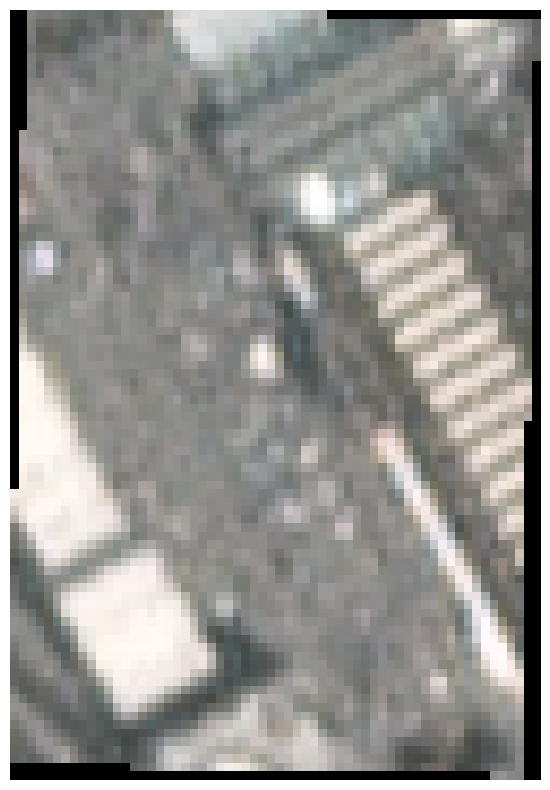

In [15]:
#plot single random image
plt.figure(figsize=(10,10))
img = rioxarray.open_rasterio(final_test_images_paths[7][7])
plt.imshow(img.data[0:3].transpose(1, 2, 0))
plt.axis('off')

(-0.5, 54.5, 40.5, -0.5)

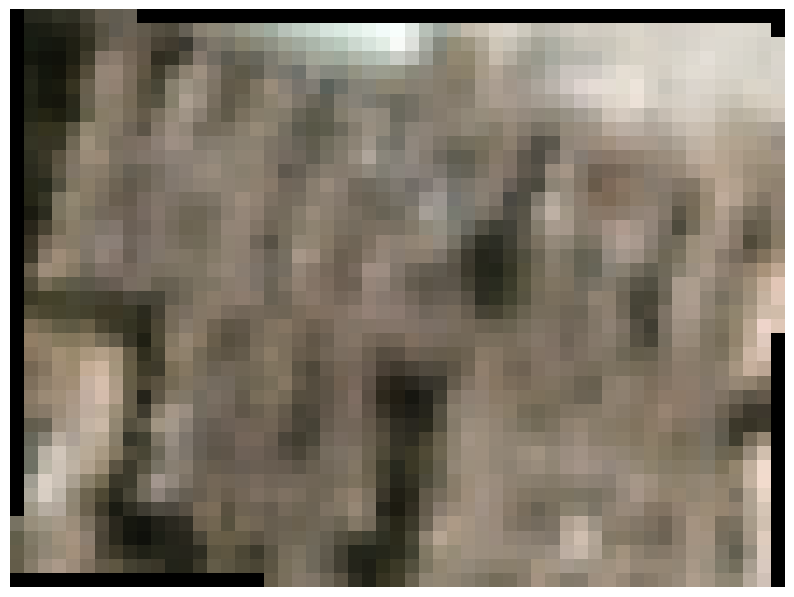

In [8]:
#plot single random image
plt.figure(figsize=(10,10))
img = rioxarray.open_rasterio(clean_3[2])
plt.imshow(img.data[0:3].transpose(1, 2, 0))
plt.axis('off')

In [1]:
#plot random 5 images from clean_3 list
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(final_test_images_paths[7][i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Time stamp(Days): {i}')
    plt.xticks([])
    plt.yticks([])


NameError: name 'plt' is not defined

In [84]:
# plt.figure(figsize=(20,20))
# for i in range(len(clean_3)):
#     plt.subplot(30,30,i+1)
#     img = rioxarray.open_rasterio(clean_3[i])
#     plt.imshow(img.data[0:3].transpose(1, 2, 0))
#     plt.axis('off')

#### Create and save median images

In [10]:
median_image, _ = create_median_image(final_train_images_paths[0])
path = "/"
for j in range(len(final_train_images_paths)):
    median_image, _ = create_median_image(final_train_images_paths[j])
    path = "/"
    for i in final_train_images_paths[j][0].split('/')[1:-2]:
        path = os.path.join(path, i)
    np.save(os.path.join(path, 'median_image.npy'), median_image)

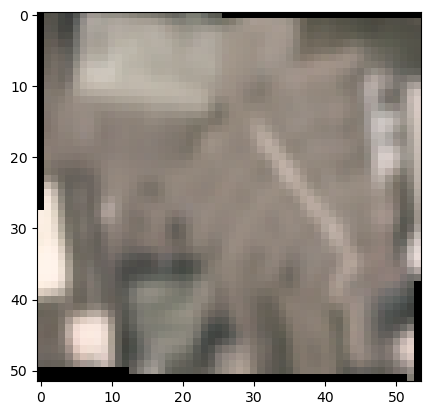

In [11]:
median_image, _ = create_median_image(final_train_images_paths[0])
plt.imshow(median_image)

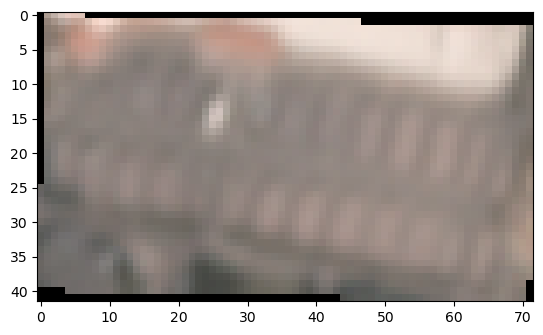

In [12]:
median_image, _ = create_median_image(final_train_images_paths[1])
plt.imshow(median_image)

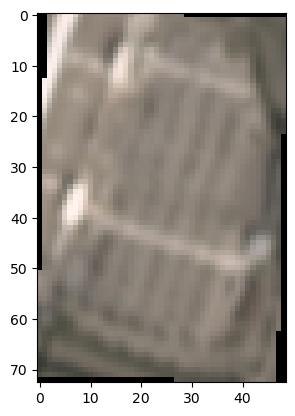

In [13]:
median_image, _ = create_median_image(final_train_images_paths[2])
plt.imshow(median_image)

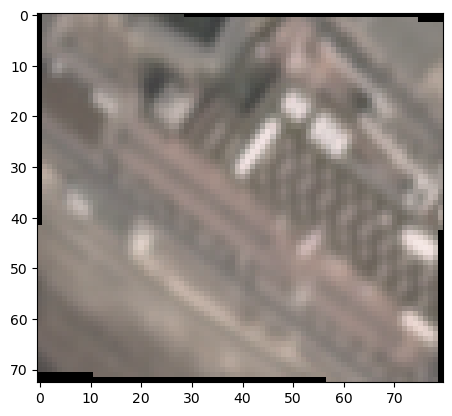

In [14]:
median_image, _ = create_median_image(final_train_images_paths[3])
plt.imshow(median_image)

In [15]:
df_train = label_csv(final_train_images_paths)

Class distribution in dataset: 0    9799
1    1518
Name: label, dtype: int64


In [22]:
list_to_remove = []
for i in df_train.image_path:
    try:
        a = rioxarray.open_rasterio(i)
    except:
        list_to_remove.append(i)

df_train.image_path == list_to_remove[0]
df_train[df_train.image_path == list_to_remove[0]]
df_train.drop(df_train[df_train.image_path == list_to_remove[0]].index.values[0], inplace=True)

In [23]:
df_train.head()

,image_path,day,label
0,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Saturday,0
1,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Saturday,0
2,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Monday,0
3,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Monday,0
4,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Thursday,0


In [24]:
df_test = label_csv(final_test_images_paths)

Class distribution in dataset: 0    2206
1     277
Name: label, dtype: int64


In [25]:
df_test.head()

,image_path,day,label
0,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Saturday,0
1,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Saturday,0
2,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Tuesday,0
3,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Saturday,0
4,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Thursday,0


#### Custom pytorch dataset loader

In [26]:
#pytorch dataset class for siamese network
class SiameseNetworkDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        # self.median_img = median_img
        self.transform = transform
        self.median_img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, idx):
        img_path = self.df.image_path.values[idx]
        path = '/'
        for i in df_train.image_path[0].split('/')[1:-2]:
            path = os.path.join(path, i)

        median_image = np.load(os.path.join(path, 'median_image.npy'))
        img_1 = rioxarray.open_rasterio(img_path)
        img_1 = img_1.data[0:3].transpose(1, 2, 0)
        label = self.df.label.values[idx]
        img_2 = self.median_img_transform(median_image)

        if self.transform:
            img_1 = self.transform(img_1)
            # img_2 = self.transform(img_2) #median image augmentation, need experiments here. 
        return img_1, img_2, label

    def __len__(self):
        return len(self.df)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
from tqdm.auto import tqdm
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#train test split
# train, test = train_test_split(df_train, test_size=0.0, random_state=42, stratify=df_train.label.values)
# test.reset_index(inplace=True, drop=True)
# train.reset_index(inplace=True, drop=True)
# print("Train size:", train.shape)
# print("Test size:", test.shape)
# #print the class distribution in train and test set
# print("Train class distribution:", train.label.value_counts())
# print("Test class distribution:", test.label.value_counts())

cuda:0


In [28]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=30),
    # transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

#dataset and dataloader
train_dataset = SiameseNetworkDataset(df_train, transform=train_transform)
test_dataset = SiameseNetworkDataset(df_test,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [29]:
for x1,x2,y in train_loader:
    print(x1.shape)
    print(x2.shape)
    print(y.shape)
    break

torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32])


#### Model

In [30]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.resnet = models.resnet18(pretrained=True)  # Load pre-trained ResNet-18
        self.resnet.fc = nn.Linear(512, 128)  # Change the fully connected layer to output 128-dimensional embeddings
        self.fc1 = nn.Linear(128 * 2, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward_one(self, x):
        x = self.resnet(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        combined = torch.cat((output1, output2), dim=1)
        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.fc2(x)
        # x = torch.sigmoid(x)
        return x


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [36]:
model = SiameseNetwork()
for param in model.parameters():
    param.requires_grad = True
    
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [37]:
#training and validation, also calculating AUC scores for train and test set
def train_model(model, criterion, optimizer, num_epochs=50):
    train_loss = []
    train_acc = []
    train_auc = []
    val_loss = []
    val_acc = []
    val_auc = []
    writer = SummaryWriter()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_auc = 0.0
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            y_pred = []
            y_true = []
            # Iterate over data.
            for input_1, input_2, labels in eval(phase+'_loader'):
                input_1 = input_1.to(device)
                input_2 = input_2.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(input_1, input_2)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * input_1.size(0)
                
                running_corrects += torch.sum(preds == labels.data)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
            epoch_loss = running_loss / len(eval(phase+'_loader').dataset)
            epoch_acc = running_corrects.double() / len(eval(phase+'_loader').dataset)
            epoch_auc = roc_auc_score(y_true, y_pred)
            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)
            writer.add_scalar(f'AUC/{phase}', epoch_auc, epoch)
            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_auc))
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_auc.append(epoch_auc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                val_auc.append(epoch_auc)
            # deep copy the model
            if phase == 'test' and epoch_auc > best_auc:
                best_acc = epoch_acc
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), '/home/akansh-i2sc/Desktop/Study/detect-car-LR/notebooks/Exp_4/models/exp_4.pt')
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val AUC: {:4f}'.format(best_auc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc




In [38]:
model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc = train_model(model, criterion, optimizer, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------
train Loss: 0.4014 Acc: 0.8655 AUC: 0.4998
test Loss: 0.4017 Acc: 0.8884 AUC: 0.5000

Epoch 1/99
----------
train Loss: 0.3929 Acc: 0.8659 AUC: 0.5000
test Loss: 0.7183 Acc: 0.8884 AUC: 0.5000

Epoch 2/99
----------
train Loss: 0.3909 Acc: 0.8659 AUC: 0.5000
test Loss: 0.4271 Acc: 0.8884 AUC: 0.5000

Epoch 3/99
----------
train Loss: 0.3931 Acc: 0.8659 AUC: 0.5000
test Loss: 0.3764 Acc: 0.8884 AUC: 0.5000

Epoch 4/99
----------
train Loss: 0.3948 Acc: 0.8659 AUC: 0.5000
test Loss: 0.3848 Acc: 0.8884 AUC: 0.5000

Epoch 5/99
----------
train Loss: 0.3939 Acc: 0.8659 AUC: 0.5000
test Loss: 0.3544 Acc: 0.8884 AUC: 0.5000

Epoch 6/99
----------
train Loss: 0.3936 Acc: 0.8659 AUC: 0.5000
test Loss: 0.3871 Acc: 0.8884 AUC: 0.5000

Epoch 7/99
----------
train Loss: 0.3932 Acc: 0.8659 AUC: 0.5000
test Loss: 0.3729 Acc: 0.8884 AUC: 0.5000

Epoch 8/99
----------
train Loss: 0.3961 Acc: 0.8659 AUC: 0.5000
test Loss: 0.4147 Acc: 0.8884 AUC: 0.5000

Epoch 9/99
----------
train 

In [38]:
train_acc_values = []
for index in range(len(train_acc)):
    train_acc_values.append(train_acc[index].item())

val_acc_values = []
for index in range(len(val_acc)):
    val_acc_values.append(val_acc[index].item())

#### Grad cam on model

In [126]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18


In [129]:
model_test = SiameseNetwork()
model_test.load_state_dict(torch.load('/home/akansh-i2sc/Desktop/Study/detect-car-LR/notebooks/Exp_4/models/exp_4.pt'))

<All keys matched successfully>

In [132]:
input_1, input_2, classes = next(iter(test_loader)) 
input_1, input_2 = input_1.to(device), input_2.to(device)
classes = classes.to(device)
outputs = model(input_1, input_2)
_, preds = torch.max(outputs, 1)
print(preds)
print(classes)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [141]:
idx = 3
input_tensor = input_1[idx].unsqueeze(0), input_2[idx].unsqueeze(0)
print("Predicted label:", preds[idx].cpu().item())
print("original class", classes[idx].cpu().item())
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

target_layers = [model_test.resnet.layer4[-1]]
cam = GradCAMPlusPlus(model=model_test, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=input_tensor)

grayscale_cam = grayscale_cam[0, :]
grayscale_cam = 1-grayscale_cam

inp = std * input_tensor.cpu().numpy().transpose((1, 2, 0)) + mean

rgb_img = np.clip(inp, 0, 1)

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=False)
plt.imshow(visualization)

Predicted label: 0
original class 0


TypeError: SiameseNetwork.forward() missing 1 required positional argument: 'input2'